In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Accenture/images

/content/drive/My Drive/Accenture/images


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
#import nltk
import re
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [4]:
images_paths = [os.path.join("Гречка/", i) for i in os.listdir("Гречка/")]
len(images_paths)

176

In [5]:
images_paths_2 = [os.path.join("Гречка и перец/", i) for i in os.listdir("Гречка и перец/")]
len(images_paths_2)

159

In [6]:
all_images = images_paths + images_paths_2
len(all_images)

335

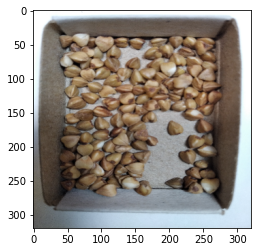

In [7]:
image = cv2.imread(all_images[100])
image = cv2.resize(image, (320, 320))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [8]:
labels = [0] * 176
labels_2 = [1] * 159
all_labels = labels + labels_2
len(all_labels)

335

In [10]:
# разобьем данные на train и test, чтобы можно было проверить качество модели
from sklearn.model_selection import train_test_split

img_train, img_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [47]:
import albumentations as A
from albumentations.pytorch import ToTensor

transform = A.Compose([
    A.Resize(width=256, height=256),  
    A.RandomCrop(width=224, height=224),  
    A.RandomBrightnessContrast(brightness_limit=0.7, contrast_limit=0.2, p=1)
    ])

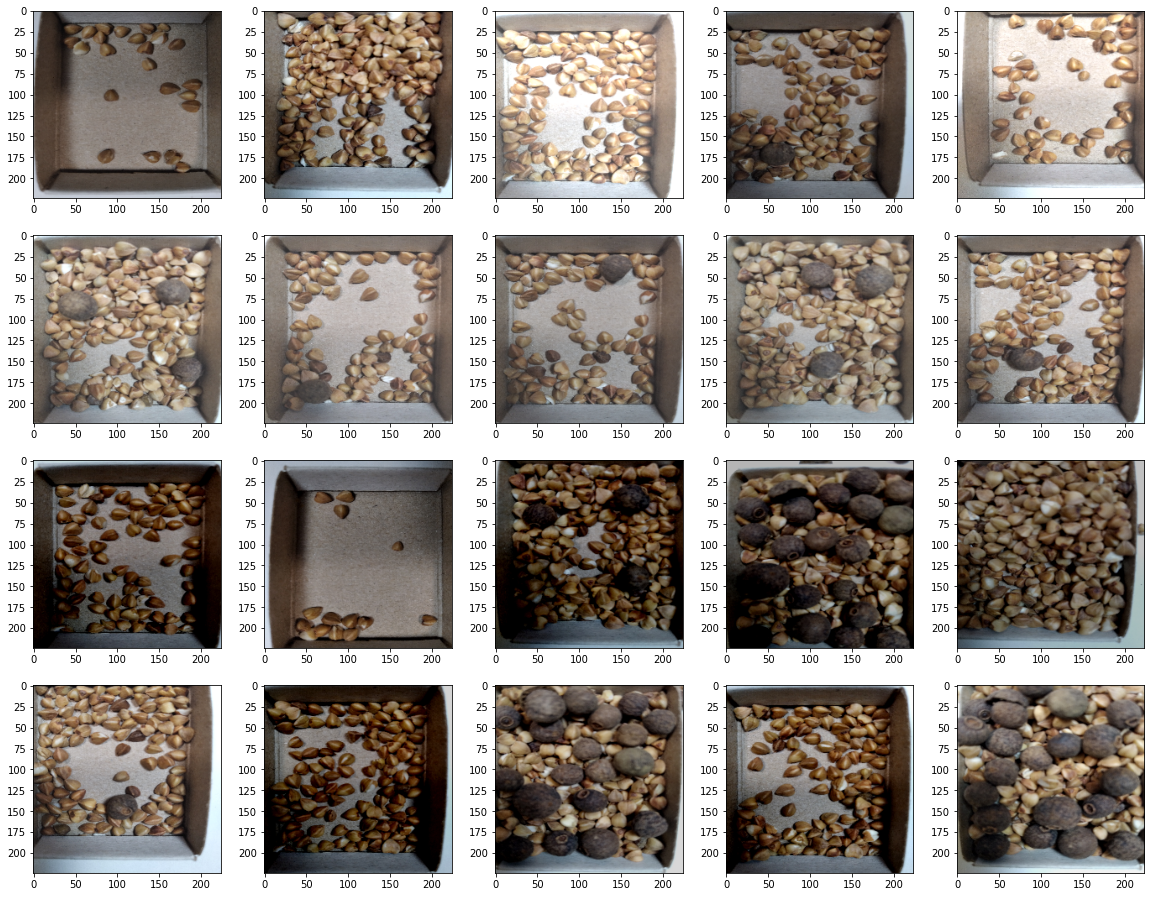

In [48]:
pic_box = plt.figure(figsize=(20,20))

# Поочередно считываем в переменную picture имя изображения из списка pictures. В переменную i записываем номер итерации
for i in range(0, 20):
    pic_box.add_subplot(5,5,i+1)
    image = cv2.imread(img_test[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed_image_1 = transform(image=image)['image']
    plt.imshow(transformed_image_1)

# выводим все созданные фигуры на экран
plt.show()    

In [49]:
transform_train = A.Compose([                         
    A.Resize(width=256, height=256),  
    A.RandomCrop(width=224, height=224),            
    A.RandomBrightnessContrast(brightness_limit=0.7, contrast_limit=0.2, p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensor()

])

transform_test = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensor()
    
])

In [50]:
from PIL import Image

class Images(Dataset):
    def __init__(self, images, labels, transform):
        self.image = images
        self.label = labels
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = cv2.imread(self.image[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image']

        lab = self.label[idx]

        return image, lab

In [67]:
len(y_train), len(y_test)

(268, 67)

In [68]:
y_test.count(0), y_test.count(1)

(39, 28)

In [69]:
train_dataset = Images(img_train, y_train, transform_train)
test_dataset = Images(img_test, y_test, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
image, label = next(iter(train_loader))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {label.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [70]:
from torchvision import models

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = True

In [71]:
class NN(nn.Module):
    def __init__(self, net_pretrained):
        super().__init__()
        self.net_pretrained = net_pretrained
        self.fc1 = nn.Linear(1000, 1)
        
    def forward(self, x):
        x = F.relu(self.net_pretrained(x))
        output = torch.sigmoid(self.fc1(x))

        return output

In [72]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

model = NN(model)
model = model.to(device)
criterion = nn.BCELoss()

num_epochs = 20
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
#model.load_state_dict(torch.load('model4.pth'))

<All keys matched successfully>

In [73]:
best_score = 0
patience = 2
impatience = 0

for i, epoch in enumerate(range(num_epochs)):

  model.train()
  epoch_acc_train = 0
  epoch_f1_train = 0
  epoch_loss = 0
  
  for images, labels in tqdm(train_loader):
    # для GPU
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)

    # прямой проход и рассчет ошибки
    outputs = model(images)
    loss = criterion(outputs, labels.unsqueeze(1))

    epoch_loss += loss.item()

    # Обратное распространение и оптимизатор
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  
    predicted = torch.round(outputs)
    epoch_acc_train += accuracy_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
    epoch_f1_train += f1_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())

  model.eval()

  epoch_acc_test = 0
  epoch_f1_test = 0

  with torch.no_grad():
    for images, labels in test_loader:
        # для GPU
        images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)

        outputs = model(images)
        predicted = torch.round(outputs)

        epoch_acc_test += accuracy_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
        epoch_f1_test += f1_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())


  acc_train = epoch_acc_train / len(train_loader)
  f1_train = epoch_f1_train / len(train_loader)

  acc_test = epoch_acc_test / len(test_loader)  
  f1_test = epoch_f1_test / len(test_loader)      

  print(i, 'Train acc:', acc_train, 'Train f1: ', f1_train)
  print(i, 'Test acc:', acc_test, 'Test f1: ', f1_test)

  if acc_test > best_score:
    torch.save(model.state_dict(), 'model4.pth')
    print("New best score. Saving model.")
    best_score = acc_test    
    impatience = 0
  else: 
    impatience += 1
    if impatience == patience:
        print("Out of patience. Stop training.")
        break

  0%|          | 0/9 [00:00<?, ?it/s]

0 Train acc: 0.869212962962963 Train f1:  0.8672464629905264
0 Test f1: 0.40277777777777773 Test f1:  0.5666666666666667
New best score. Saving model.


  0%|          | 0/9 [00:00<?, ?it/s]

1 Train acc: 0.980324074074074 Train f1:  0.9794837050934613
1 Test f1: 1.0 Test f1:  1.0
New best score. Saving model.


  0%|          | 0/9 [00:00<?, ?it/s]

2 Train acc: 0.9895833333333334 Train f1:  0.9902429311031461
2 Test f1: 0.9895833333333334 Test f1:  0.9885057471264368


  0%|          | 0/9 [00:00<?, ?it/s]

3 Train acc: 1.0 Train f1:  1.0
3 Test f1: 1.0 Test f1:  1.0
Out of patience. Stop training.


In [ ]:
model.load_state_dict(torch.load('model4.pth'))
model.eval()

In [89]:
def predictions(image, label=False):
    #image = Image.open(image)
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform_test(image=image)['image']
    gpu_img = image.to(device)

    output = model(gpu_img[None, ...])

    if label:
      predicted = torch.round(output)
      predicted = predicted.cpu().squeeze().tolist()

      return predicted

    predicted_proba = round(output.cpu().squeeze().tolist(), 2)
    return predicted_proba


In [85]:
res = [predictions(i, label=True) for i in tqdm(img_test)]

  0%|          | 0/67 [00:00<?, ?it/s]

In [86]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, res)

array([[39,  0],
       [ 0, 28]])

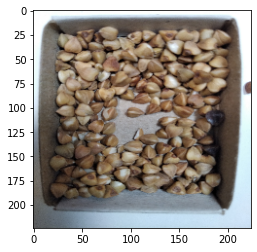

True: 0
Pred: 0.01


In [103]:
num = 22
res = predictions(img_test[num])

image = cv2.imread(img_test[num])
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

print('True:', y_test[num])
print('Pred:', res)

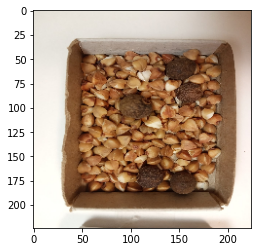

True: 1
Pred: 1.0


In [102]:
num = 12
res = predictions('test1.jpg')

image = cv2.imread('test1.jpg')
image = cv2.resize(image, (224, 224))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

print('True:', 1)
print('Pred:', res)